# E-commerce Kaggle competition

#### Clustring customers according to their product purcashes

For **downloading** data [E-commerce Data](https://www.kaggle.com/carrie1/data#data.csv)

***

#### importing modules

In [321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

from nltk import pos_tag, word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary  ## BOW
from gensim import corpora, models     ## TFIDF
from gensim.test.utils import datapath  ## save/load model
from gensim.models import LdaMulticore ## LDA-MODEL for clustering products


from kmodes.kmodes import KModes
from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.decomposition import PCA
from pprint import pprint

from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn import preprocessing, model_selection, metrics, feature_selection


import datetime, warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot, plot, download_plotlyjs
init_notebook_mode(connected=True)

In [3]:
df = pd.read_csv('ecommerce.csv', encoding="ISO-8859-1", dtype= {'CustomerID': str})  
## CustomerID  is float (1532.0)-> str while reading the dataset will remove .0 at end
## if convert it to string after reading 
## df['CustomerID'] = df['CustomerID'].astype('str')
## the .0 will be treated as character and remain in the 'CustomerID' Field

# take long time!
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


### Cleaning Data

In [4]:
nullTable = pd.DataFrame(df.dtypes ).T.rename(index={0: "types"})
nullTable = nullTable.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0: "count"}))
nullTable = nullTable.append(pd.DataFrame(df.isnull().sum() /df.shape[0]*100 ).T.rename(index={0: "%"}))
nullTable

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
types,object,object,object,int64,datetime64[ns],float64,object,object
count,0,0,1454,0,0,0,135080,0
%,0,0,0.268311,0,0,0,24.9267,0


Around 25% of Customers Ids are null ... can't deal with such prob, so we drop them

In [5]:
df.dropna(axis= 0, subset=['CustomerID'], inplace=True)

In [6]:
pd.DataFrame(df.isnull().sum()).T

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,0,0,0,0,0,0,0


Great, Now data is cleaned of null values, Now removing duplicates

In [7]:
print("There Exist {:,} duplications in our data,".format(df.duplicated().sum()))

There Exist 5,225 duplications in our data,


In [8]:
df.drop_duplicates(inplace=True)

Our data shape after such cleaning processes

In [9]:
df.shape

(401604, 8)

In [10]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


#### Exploring Data

► <b>InvoiceNo </b>: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. <br>
► <b>StockCode </b>: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>
► <b>Description </b>: Product (item) name. Nominal. <br>
► <b>Quantity </b>: The quantities of each product (item) per transaction. Numeric. <br>
► <b>InvoiceDate </b>: Invice Date and time. Numeric, the day and time when each transaction was generated. <br>
► <b>UnitPrice </b>: Unit price. Numeric, Product price per unit in sterling. <br>
► <b>CustomerID </b>: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>
► <b>Country </b>: Country name. Nominal, the name of the country where each customer resides.<br>

##### i) Country

In [11]:
print( "We have {} countires trading all over the world ".format(df.Country.nunique()))

We have 37 countires trading all over the world 


In [12]:
countries = df.Country.value_counts()
data = dict(type='choropleth',
            locations = countries.index,
            locationmode = 'country names', z = countries,
            text = countries.index, colorbar = {'title':'Orders'},
            colorscale= 'Reds',
            reversescale = False
           )
layout = dict(title='Geographic View',
                geo = dict(showframe = True, projection=dict(type = 'winkel tripel'))
             )
gmap = go.Figure(data = [data], layout = layout)
py.iplot(gmap)

Apparently most of our sales from <b style="color:red">United Kingdom</b>

In [13]:
data = [
    go.Bar(
        y = countries.index[:7],
        x = countries.values[:7],
        orientation='h',
        marker={
            'color':countries.values,
            'colorscale': 'Portland'
            }
        )
     ]

py.iplot(data, filename='basic-bar')

In [14]:
pd.DataFrame([{
    'Customers': df.CustomerID.nunique(),
    'Products': df.StockCode.nunique(),
    'Transactions': df.InvoiceNo.nunique()
            }
]).rename(index = {0:"Num"})

,Customers,Products,Transactions
Num,4372,3684,22190


In [15]:
customers = df.CustomerID.value_counts().sort_values(ascending=False)
print("99% of Users  Make {:.0f} Transactions, While Our Favourite Client Visits us {} times".
      format(np.round(customers.quantile(0.99)), customers.max()))

99% of Users  Make 658 Transactions, While Our Favourite Client Visits us 7812 times


Check How many products in each transaction

In [16]:
temp = df.groupby(by=['CustomerID','InvoiceNo'])['InvoiceDate'].count().reset_index()
temp = temp.rename(columns={'InvoiceDate':'Num. Products'})
temp.head(10)

,CustomerID,InvoiceNo,Num. Products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


##### ii) Analysis on cancelation processes

'C' character followed by the Invoice no. means that such Transcation is cancelled.

In [17]:
temp['cancels'] = temp.InvoiceNo.apply(lambda x: int(x[0] == 'C'))

temp.sort_values(by='CustomerID').head()



,CustomerID,InvoiceNo,Num. Products,cancels
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


In [18]:
print("There exist {:.2f}% Cancelations".format(temp.cancels.sum() / temp.shape[0] * 100))

There exist 16.47% Cancelations


That's not a small percent for cancelled transactions ... lets see most products being Cancelled

In [19]:
dfc = df.copy()
dfc['cancels'] = dfc.InvoiceNo.apply(lambda x: int(x[0] == 'C'))

dfc.groupby(by=['StockCode', 'Description'])['cancels'].count().sort_values(ascending=False).reset_index().head(10)


,StockCode,Description,cancels
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2058
1,22423,REGENCY CAKESTAND 3 TIER,1894
2,85099B,JUMBO BAG RED RETROSPOT,1659
3,47566,PARTY BUNTING,1409
4,84879,ASSORTED COLOUR BIRD ORNAMENT,1405
5,20725,LUNCH BAG RED RETROSPOT,1345
6,22720,SET OF 3 CAKE TINS PANTRY DESIGN,1224
7,POST,POSTAGE,1196
8,20727,LUNCH BAG BLACK SKULL.,1099
9,21212,PACK OF 72 RETROSPOT CAKE CASES,1062


Some orders were Completely canceled ... which are just duplications of their orders except that <br>
<b>Time</b> is different, <b>StockCode</b> begins with 'C', and <b>Quantity</b> is assigned a negative value<br>

Other Orders were canceled without their real orders observations <br>
Which means that such transaction made before December 2010  [ where the data begins ]

#### warning : take long time 

In [20]:
df_n = df.copy()

df_n['QuantityCancelled'] = 0
removeEntry = []; doubtEntry = []


for indexA, col in df.iterrows():
    if (col['Quantity'] > 0) or (col['Description'] == 'Discount'): continue
    temp = df.loc[(df['CustomerID'] == col['CustomerID']) &
                  (df['StockCode']  == col['StockCode'])  &
                  (df['InvoiceDate'] < col['InvoiceDate'])&
                  (df['Quantity']    >      0)].copy()
    
    ## Order Before Dec. 2010 and Cancelled after Dec 2010
    if(temp.shape[0]   == 0):
        doubtEntry.append(indexA)
    ## The real order exist
    elif(temp.shape[0] == 1):
        df_n.loc[temp.index[0], 'QuantityCancelled'] = -col['Quantity']
        removeEntry.append(indexA)
    
    ## Many real orders for such cancellation, will modify only the same Quantity, and remove the entry
    else:
        temp.sort_index(axis=0, ascending=False, inplace=True)
        for i, v in temp.iterrows():
            if v['Quantity'] < -col['Quantity'] : continue  ## cant cancel more than he bought
            df_n.loc[i, 'QuantityCancelled'] = -col['Quantity']
            removeEntry.append(indexA)
            break

In [21]:
print('To be removed: {} with percentage {:.1f}%'.format(len(removeEntry), len(removeEntry) / df_n.shape[0] *100 ))
print('Waiting: {} with percentage {:.1f}%'.format(len(doubtEntry), len(doubtEntry) / df_n.shape[0] *100 ))

To be removed: 7521 with percentage 1.9%
Waiting: 1226 with percentage 0.3%


Due to the low Percentage of the Doubtful entries, we can remove them without being highly affected 

In [22]:
df_n.drop(removeEntry, axis=0, inplace=True)
df_n.drop(doubtEntry, axis=0, inplace=True)

In [23]:
## remaining Cancelled entries ... with unknown real records ... and not discounts
temp = df_n.loc[ (df['Quantity'] < 0) & (df['StockCode'] != 'D') ]
#print("Rest of bad entries : {}".format(temp.shape[0]))

#### Total cash of the transaction

In [426]:
df_n['ttlCashe'] = df_n['UnitPrice'] * (df_n['Quantity'] - df_n['QuantityCancelled'])
df_n.sort_values(by='CustomerID').head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCancelled,ttlCashe,cat_NN,category_0,category_1,category_2,category_3,category_4,category_5,dateInt,cat_KM
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0,1295344860000000000,1
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,0,17.0,3,0.0,0.0,0.0,0.0,0.0,17.0,1302172980000000000,5
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347,Iceland,0,35.4,0,0.0,0.0,0.0,35.4,0.0,0.0,1320063900000000000,3
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347,Iceland,0,12.5,1,0.0,12.5,0.0,0.0,0.0,0.0,1320063900000000000,1
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,0,35.7,4,0.0,0.0,0.0,0.0,35.7,0.0,1320063900000000000,4


In [25]:
basket= df_n.groupby(by=['CustomerID','InvoiceNo'])['ttlCashe'].sum().reset_index()
basket= basket[basket['ttlCashe'] > 0]
basket.sort_values(by='CustomerID').head()

,CustomerID,InvoiceNo,ttlCashe
1,12347,537626,711.79
2,12347,542237,475.39
3,12347,549222,636.25
4,12347,556201,382.52
5,12347,562032,584.91


In [26]:
basket.ttlCashe.describe()

count    18398.000000
mean       456.338095
std        924.771216
min          0.380000
25%        155.355000
50%        299.390000
75%        462.957500
max      30757.000000
Name: ttlCashe, dtype: float64

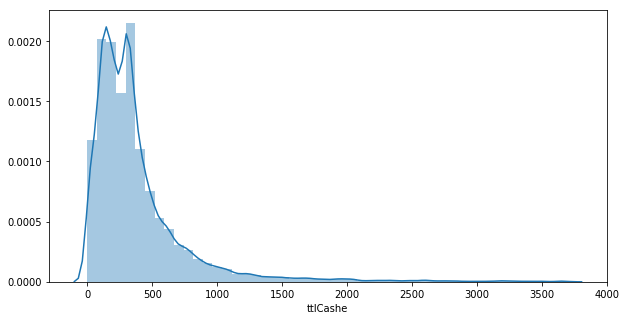

In [27]:
plt.subplots(figsize=(10, 5))
sns.distplot(basket[basket['ttlCashe'] < basket['ttlCashe'].quantile(0.99)]['ttlCashe'])
sns.axes_style()
plt.show()

In [28]:
temp = basket.copy()
temp['PriceGroups'] = pd.cut(temp['ttlCashe'], [0,50,155,300,465,1000, 10_000,31_000],
                             labels=['< 50', '50<.<155', '155<.<300', '300<.<465', '465<.<1K', '1K<10K','+10K',])



In [29]:
pieChart = go.Pie(
                labels = temp['PriceGroups'].values,
                values = temp['ttlCashe'].values,
                hole = .4
                )
layout = go.Layout(
                dict(
                    title="Sales Ranges"
                    )
                )
data = [pieChart]
py.iplot(dict(data=data, layout = layout),filename='Pie-chart')

Which indicates majority of our Sales ranges <b style="color:blue"> around 1K  - 10K £   </b>, <br>


# Clustering 

### Product Categories

Create Categories for produts according to their description, <br>
using Bag-Of-Words/ TF-IDF and **Latent diricliet allocation (LDA)** Model of clustering

**helper methods** for getting root of keywords

In [30]:
stemmer = SnowballStemmer("english")
# Tokenize and lemmatize
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))


def preprocess(text):
    result=[]
    for token in simple_preprocess(text) :
        if token not in STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

In [31]:
products = df_n['Description'].unique()
productsTkns = pd.Series(products).map(preprocess)

**Dictionary** is a key with word id and its value is the **frequency of such word all over documents**

In [32]:
dictionary = Dictionary(productsTkns)

**remove extreme tokens** (bought in less than 15 product, bought in more than 10% of all products )

In [33]:
dictionary.filter_extremes(no_below=10, no_above=0.1)

In [34]:
print("The remaining keywords to get into the model {} words".format(len(dictionary)))

The remaining keywords to get into the model 300 words


**Bag of word** technique, count **frequency of word** in each **product**

In [37]:
bow_corpus = [dictionary.doc2bow(product) for product in productsTkns]

**TF-IDF** which assign **score** for each word in each **product** according to its ***importance***

In [38]:
tfidf = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

## Clustering Products using ***LDA***

In [39]:
lda_model_tfidf = LdaMulticore(tfidf_corpus,
                                  id2word=dictionary,
                                  passes=50,
                                  num_topics=6)

Count number of **products** in each **cluster**

In [40]:
clusters = []
for doc_num in range(len(products)):
    winCat = sorted(lda_model_tfidf[bow_corpus[doc_num]], key=lambda tup: -1*tup[1])[0][0]
    clusters.append(winCat)

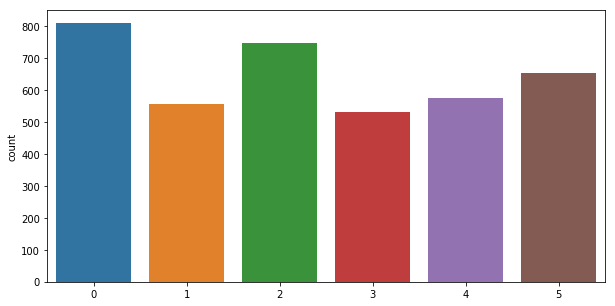

In [41]:
plt.subplots(figsize=(10, 5))
sns.countplot(pd.Series(clusters).values)
plt.show()

## WordCloud 

In [44]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

In [45]:
def make_wordCloud(topic_num, inc):
    ax1 = fig.add_subplot(4,2,inc)
    wordCloud =  WordCloud(width=1000,height=400,background_color='lightgrey',color_func = random_color_func)
    wordCloud.fit_words(dict(lda_model_tfidf.show_topic(topic_num, 200)))
    ax1.imshow(wordCloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(inc-1))


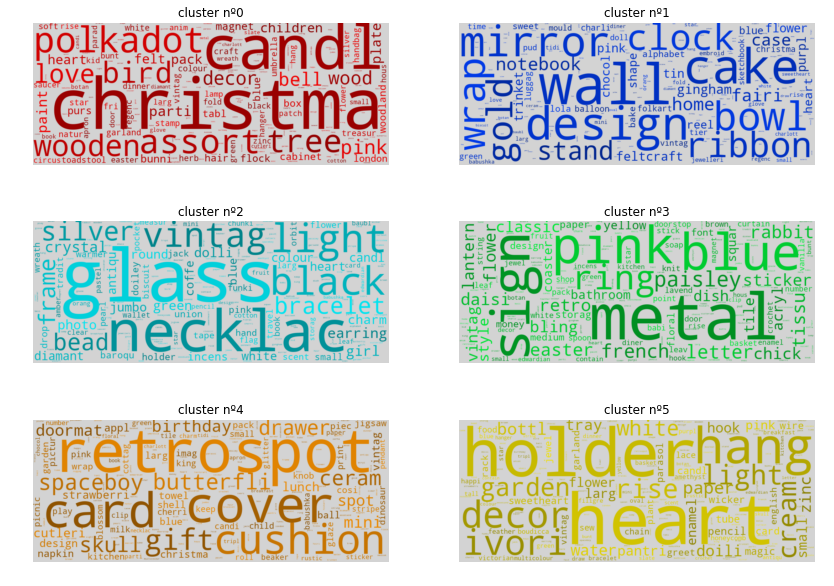

In [46]:
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for topic_num in range(lda_model_tfidf.num_topics):
    tone = color[topic_num]
    make_wordCloud(topic_num, topic_num+1) 

Some **Observations** about the Clusters <br>


for example<br> 
* Cluster 3 can be **Decoration** as contains some significant keywords like [`garden`, `wall`, `design`, `mirror`] <br>
* Cluster 5 can be **luxury items** with keywords [ `bracelet`, `necklace`, `silver`, `crystal` ]<br>
* Some other words are existing all around classes which doesn't imply important information



We assign tfIDF scores of each term of each document in a ***matrix*** for clustering purposes

In [47]:
## take the only 300 words filtered from products by dictionary
dict_prds =[]
for index, word in dictionary.iteritems():
    dict_prds.append(word)

**initialize** dictionary with **1  if such word exist in such product**, or 0 otherwise

In [48]:
X = pd.DataFrame()
for word in dict_prds:
    X.loc[:, word] = list(map( lambda x: int(word.upper() in x) , products))

assign the **tf-Idf scores** for each **word** in **product** <br>
<b style="color:skyblue">**rather than the binary-representation done above**</b>

In [49]:
for i, tf in enumerate(tfidf_corpus):
    for j, score in enumerate(tf):
        word = dictionary.get(score[0])
        X.loc[i,word] = score[1]

In [50]:
X.head()

,hang,heart,holder,light,white,lantern,metal,cream,hanger,bottl,...,pendant,boudicca,mould,point,curtain,orbit,pastel,doiley,glaze,wallet
0,0.496648,0.363789,0.473181,0.442801,0.448359,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.473390,0.719441,0.508238,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.362995,0.000000,0.000000,0.000000,0.000000,0.000000,0.588387,0.72252,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.387558,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.630069,0.000000,0.000000,0.776539,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
X.shape

(3878, 300)

Adding the <b style="color:violet">Price </b> feature, which can increase the Accuracy of clustering <br>
**7 Columns** with categorical data, for which each product range of price falls

In [74]:
priceCat = [0,1,2,3,4,5,10]
catCols = []

for i, p in enumerate(priceCat):
    if i == len(priceCat) - 1:
        col = "+{}".format(priceCat[i])
    else:
        col = "{}<.<{}".format(priceCat[i], priceCat[i+1])
    catCols.append(col)
    X.loc[:, col] = 0
    
for i, prod in enumerate(products):
    priceAvg = df_n[df_n['Description'] == prod]['UnitPrice'].mean()
    k = 0
    while priceAvg > priceCat[k]:
        k += 1
        if k == len(priceCat): break
    
    X.loc[i, catCols[k-1]] = 1


Count Products in each `Price Category` 

In [76]:
for cat in catCols:
    print(f"{cat} \t\t {X.loc[:, cat].sum()}")

0<.<1 		 964
1<.<2 		 1009
2<.<3 		 673
3<.<4 		 296
4<.<5 		 310
5<.<10 		 470
+10 		 156


## Clustering Products using KMeans

In [79]:
for n_cluster in range(3,10):
    KM = KMeans(n_clusters= n_cluster)
    clustersKM = KM.fit_predict(mat)
    silh_score = silhouette_score(mat, clustersKM)
    print("for {} clusters , Score = {}".format(n_cluster, silh_score))

for 3 clusters , Score = 0.15337625395748036
for 4 clusters , Score = 0.18884960331330075
for 5 clusters , Score = 0.20913443631878523
for 6 clusters , Score = 0.2283561184038882
for 7 clusters , Score = 0.24534888187786652
for 8 clusters , Score = 0.21409243678153422
for 9 clusters , Score = 0.23318210423915475


let's choose 6 clusters as it's from **LDA Model**

In [81]:
n_cluster =6
silh_score = -1
while silh_score < 0.22:
    KM = KMeans(n_clusters= n_cluster)
    clustersKM = KM.fit_predict(mat)
    silh_score = silhouette_score(mat, clustersKM)
print("for {} clusters , Score = {}".format(n_cluster, silh_score))

for 6 clusters , Score = 0.23208328779360246


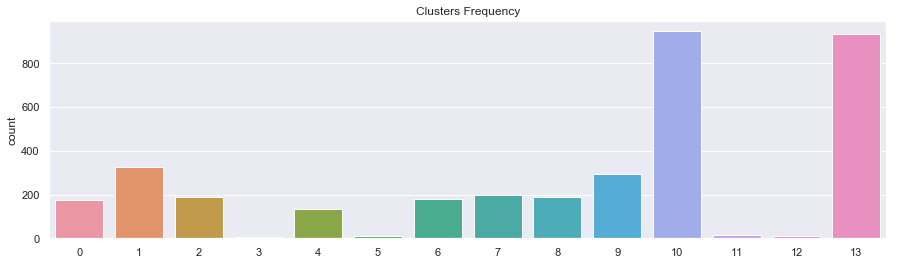

In [431]:
fig = plt.figure(figsize = (15,4))
sns.countplot(pd.Series(clustersKM))
plt.title("Clusters Frequency")
plt.show()

# PCA

In [84]:
mat = X.as_matrix()
pca = PCA()
pca_cmponents = pca.fit_transform(mat)

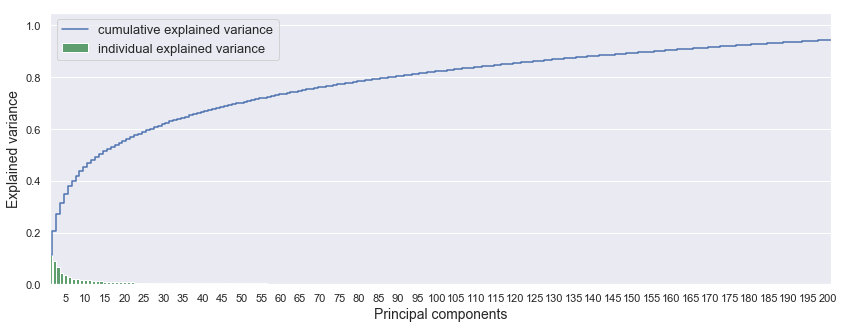

In [85]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)

plt.step(range(mat.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,mat.shape[1]+1), pca.explained_variance_ratio_, 
            color = 'g',label='individual explained variance')

plt.xlim(0, 200)

ax.set_xticklabels([s if int(s.get_text())%5 == 0 else '' for s in ax.get_xticklabels()])
plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

As we can notice, we need about **30 Principle component** to explain `60%` of data variance <br>
which indicates that such <b style="color:violet">Features</b> are **truly distinct** from each other

### Some Visualizations

In [86]:
pcdf = pd.DataFrame(pca_cmponents)
pcdf['clusters'] = pd.Series(clusters)

In [432]:
## takes Principle components in a DataFrame 
## [a, b] are 2 Princible component vectors to be plot on 2D graph
## w, h determines number of plots , w= 2, h = 3 ==> 2*3 = 6 plots can be shown
def make_pca_plot(pcomps, a, b, inc, w = 2, h = 3):
    ax = fig.add_subplot(w,h,inc)
    for cluster, color in zip(clusters, colors):
        indx = pcdf['clusters'] == cluster
        ax.scatter(pcomps.loc[indx, a],
                  pcomps.loc[indx, b],
                  c = color,
                  s = 50,
                  alpha = 0.5)
        ax.set_xlabel('PC {}'.format(a), fontsize = 15)
        ax.set_ylabel('PC {}'.format(b), fontsize = 15)


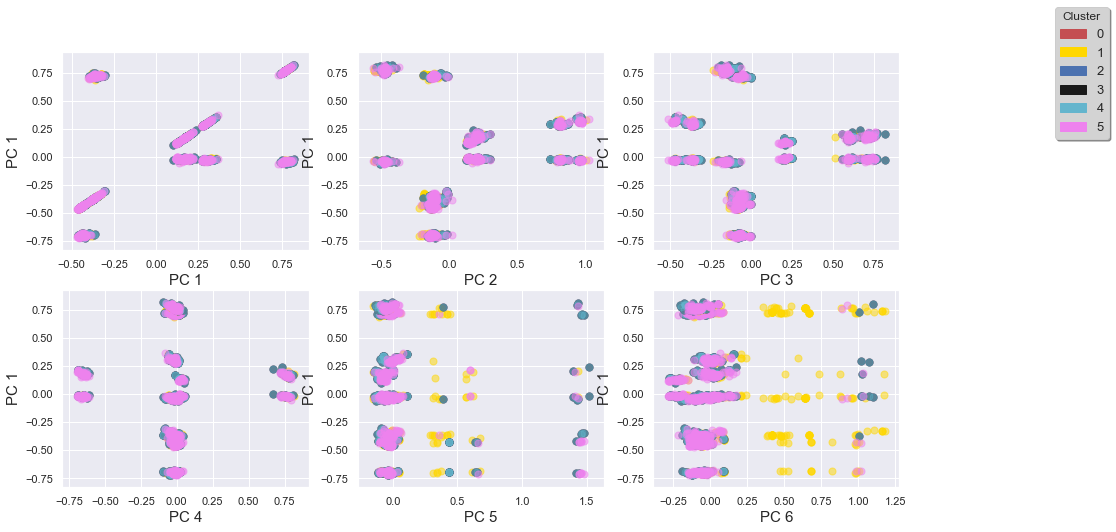

In [241]:
fig = plt.figure(figsize = (15,8))

colors = ['r','gold', 'b', 'k', 'c', 'violet']

for i in range(2):
    for j in range(6):
        make_pca_plot(pcdf,j+1,i,j+1)


LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'violet'}
comp_handler = []
for i in range(6):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles = comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure);

To be noticed, that some clusters can be separated at various **PC plots**

## Customer Categorization

After acquiring product cluster analysis, we add such information in our dataframe, adding `cat_NN` Feature which indicate category of each product, according to **`KMeans` clustering**

In [95]:
clusterAssign = dict()

for p, c in zip(products, clustersKM):
    clusterAssign[p] = c

In [96]:
df_n['cat_KM'] = df_n['Description'].map(clusterAssign)

In [97]:
df_n.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCancelled,ttlCashe,cat_NN,category_0,category_1,category_2,category_3,category_4,category_5,dateInt,cat_KM
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,5,0.0,0.0,0.0,0.00,0.0,15.30,1291191960000000000,3
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,3,0.0,0.0,0.0,20.34,0.0,0.00,1291191960000000000,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00,5,0.0,0.0,0.0,0.00,0.0,22.00,1291191960000000000,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,5,0.0,0.0,0.0,0.00,0.0,20.34,1291191960000000000,5
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,5,0.0,0.0,0.0,0.00,0.0,20.34,1291191960000000000,5


Adding **6 Features** for the ***6 product clusters***, containing the **amount of cashe** payed through each **invoice**

In [98]:
for i in range(6):
    cat  = 'category_{}'.format(i)
    temp = df_n[df_n['cat_KM'] == i]
    cashe = temp['UnitPrice'] * (temp['Quantity'] - temp['QuantityCancelled'])
    cashe = cashe.apply(lambda x: x if x > 0 else 0)
    df_n.loc[:, cat] = cashe
    df_n[cat].fillna(0, inplace = True)

In [99]:
df_n[['InvoiceNo', 'cat_KM', 'category_0','category_1', 'category_2', 'category_3', 'category_4', 'category_5']].head()

,InvoiceNo,cat_KM,category_0,category_1,category_2,category_3,category_4,category_5
0,536365,3,0.00,0.0,0.0,15.3,0.0,0.00
1,536365,0,20.34,0.0,0.0,0.0,0.0,0.00
2,536365,0,22.00,0.0,0.0,0.0,0.0,0.00
3,536365,5,0.00,0.0,0.0,0.0,0.0,20.34
4,536365,5,0.00,0.0,0.0,0.0,0.0,20.34


**Grouping each customer** to know **how much payed through each category of products**

In [100]:
df_c = df_n.copy()

In [101]:
df_c = df_n.groupby(by=['CustomerID', 'InvoiceNo'])['ttlCashe'].sum().reset_index()

for i in range(6):
    cat = "category_{}".format(i)
    temp = df_n.groupby(by=['CustomerID', 'InvoiceNo'])[cat].sum().reset_index()
    df_c.loc[:, cat] = temp[cat]

In [102]:
df_c = df_c[df_c['ttlCashe'] > 0]
df_c.rename(columns={'ttlCashe':'basketPrice'}, inplace = True)

df_c.head()


,CustomerID,InvoiceNo,basketPrice,category_0,category_1,category_2,category_3,category_4,category_5
1,12347,537626,711.79,219.00,187.2,23.40,83.40,124.44,74.35
2,12347,542237,475.39,130.95,130.5,84.34,53.10,0.00,76.50
3,12347,549222,636.25,68.25,330.9,81.00,71.10,0.00,85.00
4,12347,556201,382.52,101.16,74.4,41.40,78.06,19.90,67.60
5,12347,562032,584.91,94.41,109.7,61.30,119.70,97.80,102.00


### splitting Data with time Parameter

take the **average** of date for each entry in our `df_c` dataframe

In [103]:
df_n['dateInt'] = df_n['InvoiceDate'].astype('int64')
temp = df_n.groupby(by=['CustomerID', 'InvoiceNo'])['dateInt'].mean().reset_index()
df_c['Date'] = pd.to_datetime(temp['dateInt'])

In [104]:
df_c.head()

,CustomerID,InvoiceNo,basketPrice,category_0,category_1,category_2,category_3,category_4,category_5,Date
1,12347,537626,711.79,219.00,187.2,23.40,83.40,124.44,74.35,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,130.95,130.5,84.34,53.10,0.00,76.50,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,68.25,330.9,81.00,71.10,0.00,85.00,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,101.16,74.4,41.40,78.06,19.90,67.60,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,94.41,109.7,61.30,119.70,97.80,102.00,2011-08-02 08:48:00.000000000


In [105]:
print("First Date {}, \nlast Date {}".format(df_c['Date'].min(), df_c['Date'].max()) )

First Date 2010-12-01 08:26:00, 
last Date 2011-12-09 12:50:00


Split data with **10 months** to be training, **2 months** for testing

In [106]:
train_set = df_c[df_c['Date'] < datetime.date(2011,10,1)]
test_set  = df_c[df_c['Date'] >= datetime.date(2011,10,1)]
df_c = train_set.copy(deep=True)

In [107]:
df_c.head()

,CustomerID,InvoiceNo,basketPrice,category_0,category_1,category_2,category_3,category_4,category_5,Date
1,12347,537626,711.79,219.00,187.2,23.40,83.40,124.44,74.35,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,130.95,130.5,84.34,53.10,0.00,76.50,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,68.25,330.9,81.00,71.10,0.00,85.00,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,101.16,74.4,41.40,78.06,19.90,67.60,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,94.41,109.7,61.30,119.70,97.80,102.00,2011-08-02 08:48:00.000000000


Gather some information about each **Customer** <br>
* Number of products bought
* [Total / Avg / min / max]  cashe payed each time

In [119]:
df_Cust = df_c.groupby(by='CustomerID')['basketPrice'].agg(['count','sum','mean','min','max'])

In [120]:
df_Cust.head()

,count,sum,mean,min,max
CustomerID,,,,,
12347,5,2790.86,558.172000,382.52,711.79
12348,4,1797.24,449.310000,227.44,892.80
12350,1,334.40,334.400000,334.40,334.40
12352,6,2073.98,345.663333,144.35,840.30
12353,1,89.00,89.000000,89.00,89.00


Normalizing the Categories with `sum` column

In [121]:
for i in range(6):
    col = 'category_{}'.format(i)
    df_Cust.loc[:, col] = df_c.groupby(by='CustomerID')[col].sum() / df_Cust['sum'] * 100
df_Cust.reset_index(inplace=True, drop=False)

In [122]:
df_Cust.head()

,CustomerID,count,sum,mean,min,max,category_0,category_1,category_2,category_3,category_4,category_5
0,12347,5,2790.86,558.172000,382.52,711.79,21.992146,29.836681,10.442659,14.524555,8.676179,14.527780
1,12348,4,1797.24,449.310000,227.44,892.80,20.030714,41.953217,38.016069,0.000000,0.000000,0.000000
2,12350,1,334.40,334.400000,334.40,334.40,11.961722,48.444976,11.692584,27.900718,0.000000,0.000000
3,12352,6,2073.98,345.663333,144.35,840.30,57.105179,12.892120,0.491808,3.370331,14.301006,11.839555
4,12353,1,89.00,89.000000,89.00,89.00,44.719101,13.033708,0.000000,19.887640,22.359551,0.000000


Such dataframe provide information on each Customer, and which category he is most likely to buy from

### Data Encoding

Taking such information, and start clustering Customers

In [124]:
features = [col for col in df_Cust.columns if col != "CustomerID"]

In [126]:
df_selected = df_Cust.copy()
df_selected = df_selected[features]
matrx = df_selected.as_matrix()

**Scaling** The matrix features due to different ranges in our `matrix`

In [130]:
scaler = StandardScaler()
scaled_matrx = scaler.fit_transform(matrx)

## PCA

In [136]:
pca = PCA()
pca_comp = pca.fit_transform(scaled_matrx)

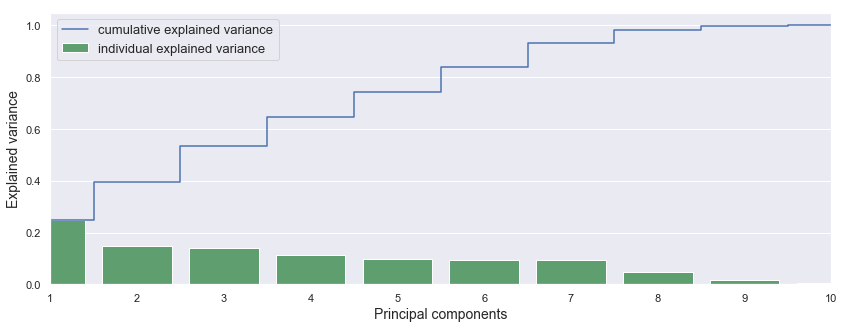

In [142]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)

plt.step(range(scaled_matrx.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,scaled_matrx.shape[1]+1), pca.explained_variance_ratio_, 
            color = 'g',label='individual explained variance')

plt.xlim(0, 9)

#ax.set_xticklabels([s if int(s.get_text())%5 == 0 else '' for s in ax.get_xticklabels()])
plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

## Clustering Customers with KMeans

In [153]:
for n_cluster in range(4,15):
    KM = KMeans(n_clusters= n_cluster)
    clustersKM = KM.fit_predict(scaled_matrx)
    silh_score = silhouette_score(scaled_matrx, clustersKM)
    print("for {} clusters , Score = {}".format(n_cluster, silh_score))

for 4 clusters , Score = 0.1508147337785531
for 5 clusters , Score = 0.14153018741071707
for 6 clusters , Score = 0.14687928620071178
for 7 clusters , Score = 0.15775635660139958
for 8 clusters , Score = 0.16823943038611078
for 9 clusters , Score = 0.19130841487370182
for 10 clusters , Score = 0.1867677374556713
for 11 clusters , Score = 0.19250562372616464
for 12 clusters , Score = 0.19762875909151104
for 13 clusters , Score = 0.17191568632758947
for 14 clusters , Score = 0.1784581238226447


let's choose `11` as number of Customer clusters

In [262]:
n_cluster =11
silh_score = -1
while silh_score < 0.19:
    KM = KMeans(n_clusters= n_cluster)
    clustersKMcust = KM.fit_predict(scaled_matrx)
    silh_score = silhouette_score(scaled_matrx, clustersKMcust)
print("for {} clusters , Score = {}".format(n_cluster, silh_score))

for 11 clusters , Score = 0.19158374716549142


In [263]:
dfpc = pd.DataFrame(pca_comp)
dfpc['clusters'] = pd.Series(clustersKMcust)

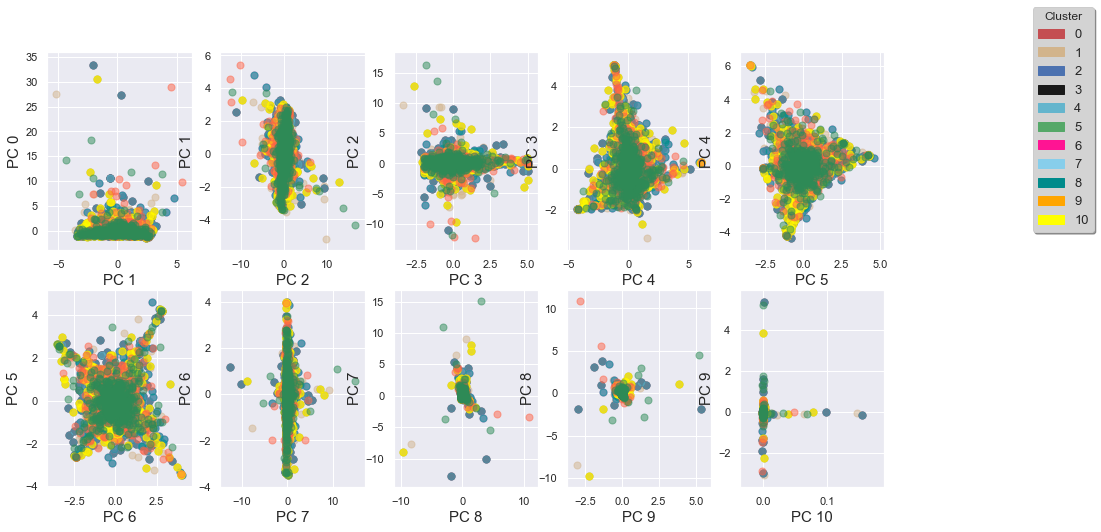

In [264]:
fig = plt.figure(figsize = (15,8))

colors = ['r','tan', 'b', 'k', 'c', 'g', 'deeppink', 'skyblue', 'darkcyan', 'orange', 'yellow','tomato','seagreen']

for j in range(10):
    make_pca_plot(dfpc, j+1, j, j+1, w=2, h=5)


LABEL_COLOR_MAP2 = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
comp_handler = []
for i in range(n_cluster):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP2[i], label = i))

plt.legend(handles = comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure);


In [266]:
pd.DataFrame(pd.Series(clustersKMcust).value_counts()).T

,10,1,4,2,0,9,5,7,8,6,3
0,1453,509,355,339,287,238,200,191,21,10,5


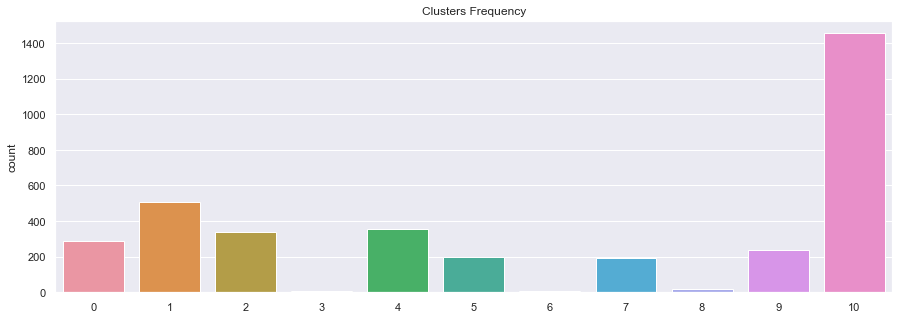

In [433]:
plt.figure(figsize = (15,5))
sns.countplot(pd.Series(clustersKMcust))
plt.title("Clusters Frequency")
plt.show()

In [267]:
df_Cust['cluster']= clustersKMcust
df_Cust.head()

,CustomerID,count,sum,mean,min,max,category_0,category_1,category_2,category_3,category_4,category_5,cluster
0,12347,5,2790.86,558.172000,382.52,711.79,21.992146,29.836681,10.442659,14.524555,8.676179,14.527780,10
1,12348,4,1797.24,449.310000,227.44,892.80,20.030714,41.953217,38.016069,0.000000,0.000000,0.000000,1
2,12350,1,334.40,334.400000,334.40,334.40,11.961722,48.444976,11.692584,27.900718,0.000000,0.000000,1
3,12352,6,2073.98,345.663333,144.35,840.30,57.105179,12.892120,0.491808,3.370331,14.301006,11.839555,0
4,12353,1,89.00,89.000000,89.00,89.00,44.719101,13.033708,0.000000,19.887640,22.359551,0.000000,0


### Cluster's morphology

**Final dataframe** will contain information of each cluster:
* number of customers it contains **`size`** feature
* how much spent in each catogeory
* min / max / Avg  spent

We grab each cluster and take **average** of its information, then append it to the **Final dataframe**

In [316]:
df_final = df_Cust.groupby(by='cluster').mean().reset_index()
df_final['size']= df_Cust.groupby('cluster')['CustomerID'].count() 

In [317]:
df_final

,cluster,count,sum,mean,min,max,category_0,category_1,category_2,category_3,category_4,category_5,size
0,0,2.641115,888.509164,277.294072,201.266341,399.949477,53.157993,11.619512,4.944707,11.467712,13.072578,5.758401,287
1,1,2.420432,698.998175,278.723640,225.286287,338.861790,6.813878,55.521407,13.547181,13.630530,5.866588,4.623341,509
2,2,2.911504,1008.336962,299.262840,210.082153,407.170855,6.149112,15.714213,7.745794,58.331152,7.833169,4.226561,339
3,3,35.000000,149093.054000,4776.332726,44.824000,20679.502000,16.416885,20.823060,8.298915,20.277707,21.843223,12.340210,5
4,4,2.611268,701.103130,249.942679,194.109665,320.342845,11.768668,11.689974,5.244506,11.803100,51.818080,7.691567,355
5,5,1.885000,555.681550,270.069252,222.033850,328.074750,10.416014,14.531685,7.551935,14.340524,11.030468,42.129374,200
6,6,1.400000,7733.947000,5053.992000,3628.991000,6478.993000,10.229931,21.948648,24.532637,17.275408,16.412512,9.600865,10
7,7,2.036649,2884.657859,1283.323391,1045.755393,1590.989639,16.919262,25.668015,11.787133,21.587392,14.063689,9.974862,191
8,8,54.047619,36474.050000,962.222905,39.545714,4587.003333,13.301186,22.254137,12.143985,30.464849,14.311226,7.533235,21
9,9,2.163866,573.024412,245.616857,192.395336,315.180882,5.012146,18.319290,56.784213,11.295811,5.569474,3.019067,238


## Radar Chart

#### Chart indicates how <b style="color:red">customer clusters</b> are more likely to buy from such <b style="color:red">product clusters </b>

In [303]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

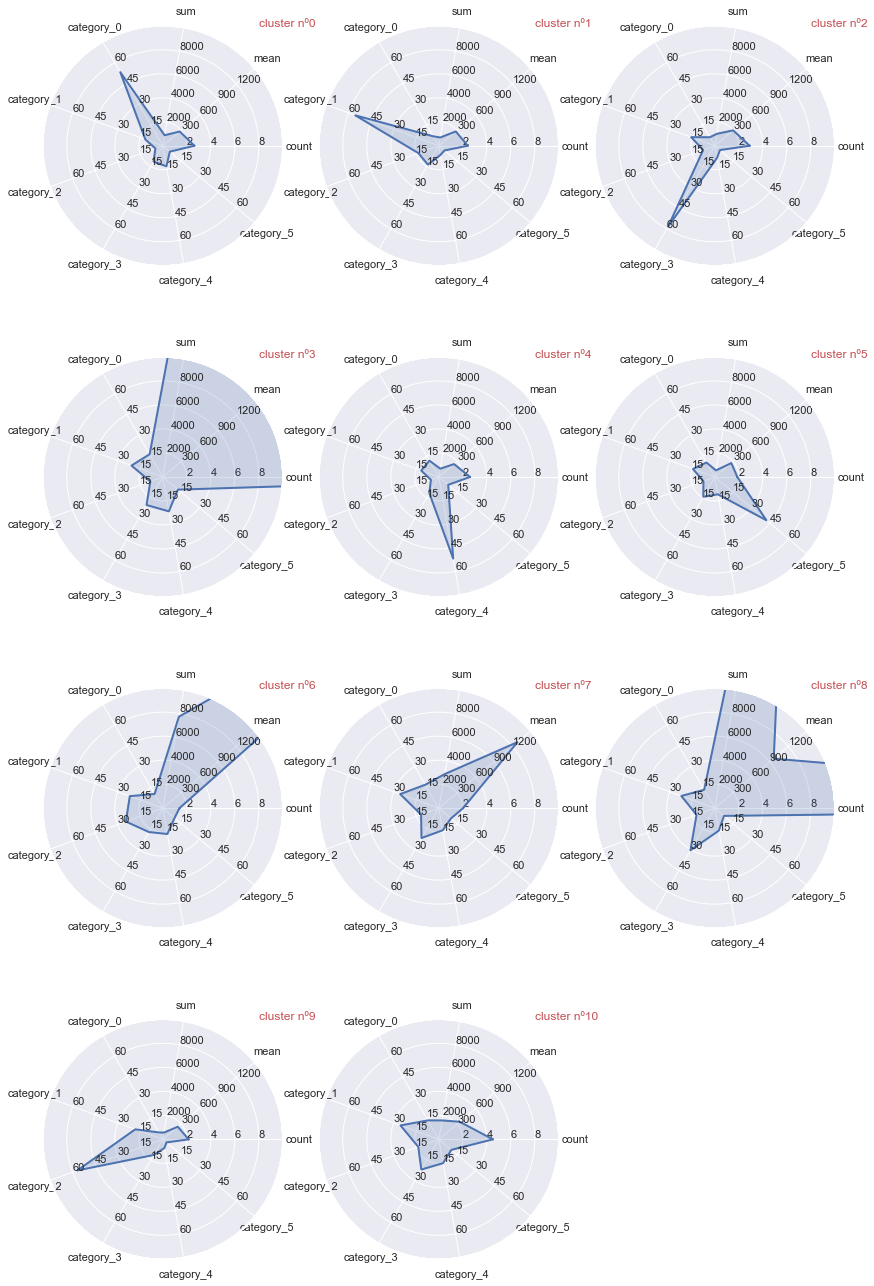

In [307]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'category_0', 'category_1', 'category_2', 'category_3', 'category_4', 'category_5']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_cluster ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_cluster):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    data = np.array(df_final.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1 

Such fabulous chart indicates how **Clusters** are more to buy from such **Category** 
* Customers of **Cluster 0** are <b style="color:violet">highly biased</b> to buy products from **0 category**
* Customers of **Cluster 1** are also impressed with **category 1** products
* Customers of **Cluster 2** more to buy products from **category 3** than any other category

# Classification

#### classifying is for predicting what customer would buy on his next visit
We try various models to get the best classification accuracy for our customers<br><br>
`Clasification` class is for the ease of the common methods of models we try

In [350]:
class Classification(object):
    ''' for Various classifiers uses '''
    def __init__(self, clfr, params=None):
        if params:
            self.clfr = clfr(**params)
        else:
            self.clfr = clfr()
    
    def train(self, x_train, y_train):
        self.clfr.fit(x_train, y_train)
    
    def predict(self, x):
        self.clfr.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(self.clfr,parameters, cv=Kfold)
    
    def grid_fit(self, X, Y):
        self.grid.fit(X,Y)
    
    def grid_predict(self, X, Y):
        self.yhat = self.grid.predict(X)
        print("Accuracy : {:.2f}".format(metrics.accuracy_score(Y, self.yhat)*100))
    

Determine the **input** `X` matrix, and `y` vector **Output**

In [355]:
Xcols = [col for col in df_selected.columns if 'categ' in col]

X = df_Cust[Xcols]
Y = df_Cust['cluster']

### **splitting** the data to train and validation datasets

In [356]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, train_size=0.8)

#### SVC

slow

In [357]:
svc = Classification(clfr= svm.LinearSVC)
svc.grid_search(parameters=[{'C':np.logspace(-2,2,10)}], Kfold = 5)
# best C=0.0278
svc.grid_fit(X= X_train, Y=y_train)
svc.grid_predict(X=X_test, Y=y_test)

Accuracy : 85.32


#### Logistic Regression

fast

In [358]:
lr = Classification(clfr= linear_model.LogisticRegression)
lr.grid_search(parameters=[{'C':np.logspace(-2,2,10)}], Kfold = 5)
## best C=0.0278
lr.grid_fit(X= X_train, Y=y_train)
lr.grid_predict(X=X_test, Y=y_test)

Accuracy : 85.04


#### K-NN

fast

In [359]:
knn = Classification(clfr= neighbors.KNeighborsClassifier)
knn.grid_search(parameters=[{'n_neighbors':np.arange(1,50,1)}], Kfold = 5)
## best 12
knn.grid_fit(X= X_train, Y=y_train)
knn.grid_predict(X=X_test, Y=y_test)

Accuracy : 85.04


####  Decision Tree

fast

In [363]:
dtr = Classification(clfr= tree.DecisionTreeClassifier)
dtr.grid_search(parameters=[{'criterion':['entropy', 'gini'], 'max_features':['sqrt', 'log2'] }], Kfold = 5)
## best 'gini', 'sqrt'
dtr.grid_fit(X= X_train, Y=y_train)
dtr.grid_predict(X=X_test, Y=y_test)

Accuracy : 80.61


#### Random Forest

slow

In [364]:
rf = Classification(clfr= ensemble.RandomForestClassifier)
params = [{'criterion':['entropy','gini'], 'n_estimators': [20, 40, 60, 80, 100], 'max_features':['sqrt','log2']}]
## best 'gini', 20 , sqrt
rf.grid_search(parameters=params, Kfold = 5)
rf.grid_fit(X= X_train, Y=y_train)
rf.grid_predict(X=X_test, Y=y_test)

Accuracy : 87.67


#### Ada Boost

medium

In [367]:
ada = Classification(clfr= AdaBoostClassifier)
params = [{'n_estimators': [x for x in np.arange(10,100,10)]}]  ## best 50
ada.grid_search(parameters=params, Kfold = 5)
ada.grid_fit(X= X_train, Y=y_train)
ada.grid_predict(X=X_test, Y=y_test)

Accuracy : 58.31


#### Gradient Boosting 

slow

In [368]:
gbo = Classification(clfr= ensemble.GradientBoostingClassifier)
params = [{'n_estimators': [x for x in np.arange(10,100,10)]}] ## best 20
gbo.grid_search(parameters=params, Kfold = 5)
gbo.grid_fit(X= X_train, Y=y_train)
gbo.grid_predict(X=X_test, Y=y_test)

Accuracy : 86.84


### Voting

using the `VotingClassifier` Object

In [372]:
svc_best = svm.LinearSVC(**svc.grid.best_params_)
lr_best = linear_model.LogisticRegression(**lr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
dtr_best = tree.DecisionTreeClassifier(**dtr.grid.best_params_)
rf_best = ensemble.RandomForestClassifier(**rf.grid.best_params_)
ada_best = AdaBoostClassifier(**ada.grid.best_params_)
gbo_best = ensemble.GradientBoostingClassifier(**gbo.grid.best_params_)

In [389]:
votingClsf = ensemble.VotingClassifier(estimators= [('svc',svc_best),
                                                    ('lr', lr_best),
                                                    ( 'knn', knn_best),
                                                    ('dtr', dtr_best),
                                                    ('gbo', gbo_best)])

In [390]:
votingClsf= votingClsf.fit(X_train, y_train)

In [391]:
yhat = votingClsf.predict(X_test)
print("Accuracy : {:.2f}".format(metrics.accuracy_score(y_test, yhat) *100))

Accuracy : 86.98


#  Testing Predictions

##### on the 2 months `test_set`

Formating data with same processes of the `training_set` done

In [392]:
## Grouping for each user the same Features
df_c = test_set.copy(deep = True)

df_Cust = df_c.groupby(by='CustomerID')['basketPrice'].agg(['count','sum','mean','min','max'])

for i in range(6):
    col = 'category_{}'.format(i)
    df_Cust.loc[:, col] = df_c.groupby(by='CustomerID')[col].sum() / df_Cust['sum'] * 100

df_Cust.reset_index(inplace=True, drop=False)

In [416]:
features = [col for col in df_Cust.columns if col != "CustomerID"]
matrx_test = df_Cust[features].values
scaled_matrx_test = scaler.transform(matrx_test)

In [417]:
y = KM.predict(scaled_matrx_test)

In [418]:
y.shape

(2551,)

In [419]:
Xcols = [col for col in df_selected.columns if 'categ' in col]
X = df_Cust[Xcols]

In [420]:
X.shape

(2551, 6)

In [422]:
clsfrX = [svc, lr, knn, dtr, rf, ada, gbo]
clsfrLabels = ['support Vecotor Machine', 'Logostic Regression', 'k-Nearest Neighbors',
               'Decision Tree', 'Random Forest', 'Gradient Boosting']

classifiers = [(x, y) for x,y in zip(clsfrX, clsfrLabels)]
for clf, label in classifiers:
    print(30*"-", '\n{}'.format(label))
    clf.grid_predict(X,y)

------------------------------ 
support Vecotor Machine
Accuracy : 86.12
------------------------------ 
Logostic Regression
Accuracy : 85.69
------------------------------ 
k-Nearest Neighbors
Accuracy : 85.77
------------------------------ 
Decision Tree
Accuracy : 79.50
------------------------------ 
Random Forest
Accuracy : 87.97
------------------------------ 
Gradient Boosting
Accuracy : 62.92


In [425]:
predictions = votingClsf.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(y, predictions)))

Precision: 87.38 % 
